ДОМАШНЕЕ ЗАДАНИЕ
ЗАДАЧА В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные можно использовать для построения персонализированных ИИ-ассистентов для поддержки обучения студента. Пока сосредоточимся на начальном этапе — сборе и подготовке данных.

ВАМ НЕОБХОДИМО: Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

РЕСУРСЫ: Данные

Результат прислать в формате ссылки на Github с ноутбуком

ОПИСАНИЕ ДАННЫХ Для выполнения задания вам необходимы файлы train.csv, lectures.csv, questions.csv.

TRAIN.CSV row_id: (int64) ID code for the row. timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user. user_id: (int32) ID code for the user. content_id: (int16) ID code for the user interaction content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture. task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures. answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures. prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle. prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

QUESTIONS.CSV: METADATA FOR THE QUESTIONS POSED TO USERS. question_id: foreign key for the train/test content_id column, when the content type is question (0). bundle_id: code for which questions are served together. correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right. part: the relevant section of the TOEIC test. tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

LECTURES.CSV: METADATA FOR THE LECTURES WATCHED BY USERS AS THEY PROGRESS IN THEIR EDUCATION. lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1). part: top level category code for the lecture. tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together. type_of: brief description of the core purpose of the lecture.

1. Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

2. Загружаем данные

Ввиду большего размера файла train.csv, актуализируем данные через словарь dtypes_train

In [4]:
dtypes_train = {
    'timestamp': 'uint64',
    'user_id': 'uint32',
    'content_id': 'uint16',
    'content_type_id': 'int8',
    'task_container_id': 'uint16',
    'answered_correctly': 'int8',
    'user_answer': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

Удалим нумерацию строк через исключение столбца 'row_id'

In [5]:
columns_train = [
    'timestamp',
    'user_id',
    'content_id',
    'content_type_id',
    'task_container_id',
    'answered_correctly',
    'user_answer',
    'prior_question_elapsed_time',
    'prior_question_had_explanation'
]

Загрузим файлы lectures.csv, questions.csv, train.csv (с ограничением по кол-ву выгруженных строк, ибо памяти мало)

In [10]:
df_lectures = pd.read_csv(r'C:\Users\User\Documents\УРФУ\Python\ДЗ - 3\lectures.csv')
df_questions = pd.read_csv(r'C:\Users\User\Documents\УРФУ\Python\ДЗ - 3\questions.csv')
df_train = pd.read_csv(r'C:\Users\User\Documents\УРФУ\Python\ДЗ - 3\train.csv', dtype=dtypes_train, usecols=columns_train, nrows=100000)

Рассмотрим загруженные файлы

lectures.csv

In [17]:
lectures_df = df_lectures.copy()
lectures_df

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


questions.csv

In [18]:
questions_df = df_questions.copy()
questions_df

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


train.csv

In [19]:
train_df = df_train.copy()
train_df

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...
99995,153647401,2078569,4334,0,275,3,0,6000.0,True
99996,153692472,2078569,6436,0,276,3,0,9000.0,True
99997,153722998,2078569,6446,0,277,2,1,21000.0,True
99998,153759775,2078569,3715,0,278,3,0,12000.0,True


Попробуем проанализировать

lectures

In [20]:
df_lectures.describe() # статистика по числовым признакам 

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [22]:
df_lectures.head(5) # выведем пять первых трок

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


Проверим наличие дубликатов и пропусков

In [23]:
df_lectures.duplicated().sum()

0

In [24]:
df_lectures.isna().sum()

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

Определим связи между описанием лекций и разделами

<AxesSubplot: xlabel='part', ylabel='Count'>

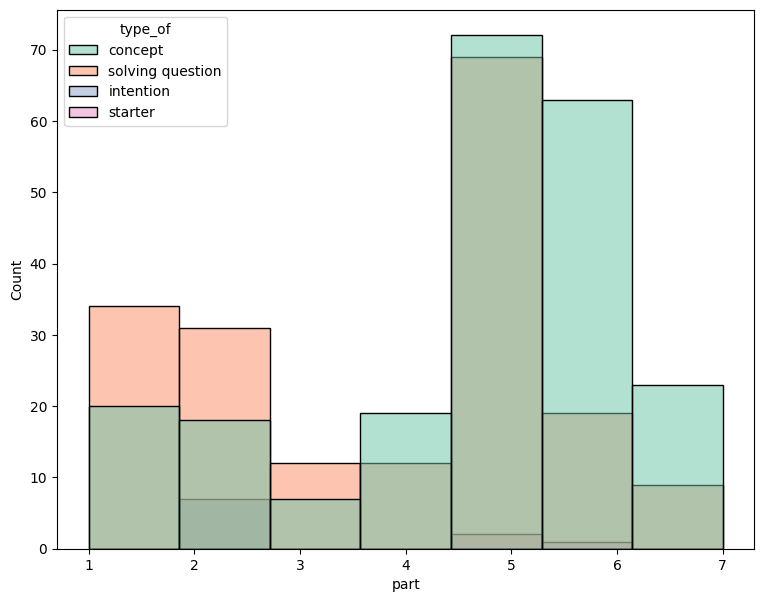

In [26]:
fig = plt.figure(figsize=(9,7))
sns.histplot(data = df_lectures, # какой датафрейм используем
             x = 'part', # какую переменную отрисовываем
             hue = 'type_of', # какую переменную используем для подкрашиваиния данных. 
             bins = 7, # на сколько ячеек разбиваем 
             palette='Set2') # какую цветовую карту используем.

Из графика видно что, в разделах с 4 по 7 больше теории, нежели практики

Распределим данные

<AxesSubplot: xlabel='part', ylabel='tag'>

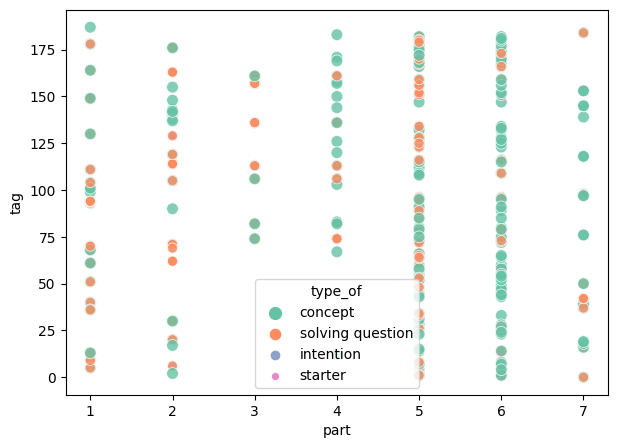

In [28]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data = df_lectures, x="part", y="tag", hue="type_of", size = "type_of", alpha = 0.8, palette='Set2')

questions

In [29]:
df_questions.describe() # статистика по числовым признакам 

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


In [30]:
df_questions.head(5) # выведем пять первых трок

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Проверим наличие дубликатов и пропусков

In [31]:
df_questions.duplicated().sum()

0

In [32]:
df_questions.isna().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

поиск пропуска

In [33]:
questions_df[questions_df.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


замена пропуска на '0'

In [34]:
questions_df.loc[10033, ('tags')] = '0'
questions_df.iloc[10033]['tags']

'0'

составим список тегов

In [36]:
tags_list = []
for i in questions_df['tags'].values:
    tags_list.extend(i)

выведем среднее кол-во тегов на вопрос

In [42]:
print(f"Среднее число тегов на вопрос = {round(len(tags_list) / questions_df.shape[0], 2)}")

Среднее число тегов на вопрос = 6.54


выведем число уникальных тегов

In [43]:
tags_set = set(tags_list)
print(f"Число уникальных тегов = {len(tags_set)}")

Число уникальных тегов = 11


создадим список тегов в Scroll

In [46]:
tags_scroll = pd.Series(tags_list)
tags_scroll.value_counts()

1    17495
     17470
2     9572
3     8360
8     7659
9     6959
6     5290
7     4436
4     3887
0     3882
5     3434
dtype: int64

Посмотрим наиболее часто используемые тэги

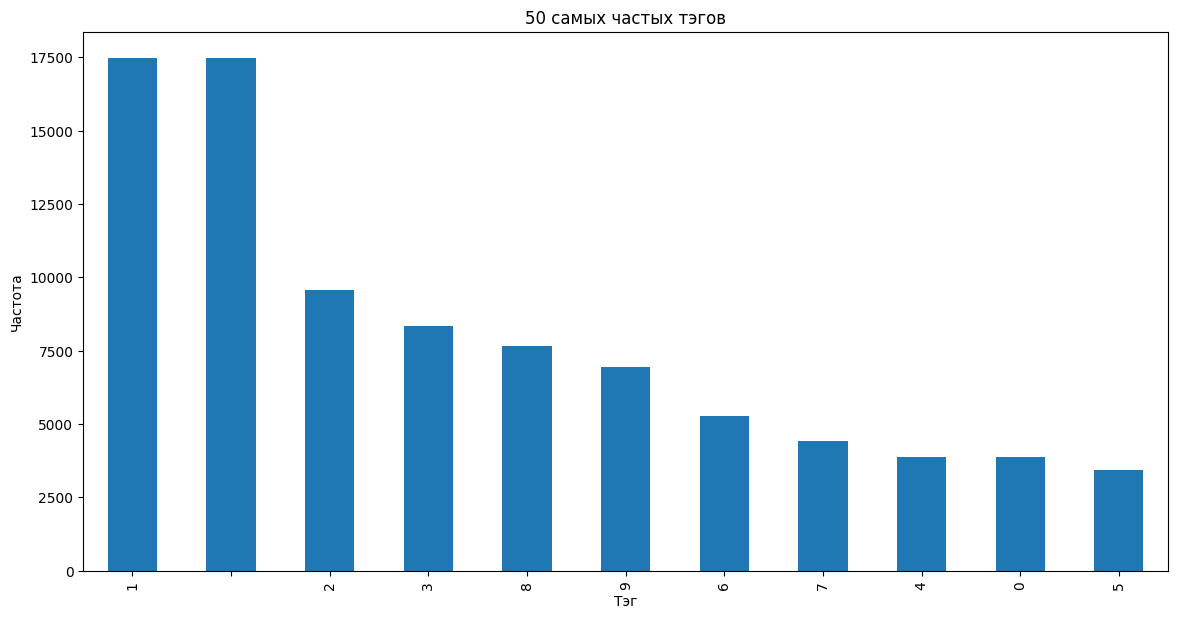

In [55]:
plt.figure(figsize=(12,5))
tags_scroll.value_counts().head(50).plot.bar()
plt.title('50 самых частых тэгов')
plt.xlabel('Тэг')
plt.ylabel('Частота')
plt.xticks(rotation=90)
plt.show()

Здесь видим явных лидера по тегам: 1 

train

In [57]:
df_train.describe() # статистика по числовым признакам 

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.000000e+05,1.000000e+05,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,97834.000000
mean,7.332661e+09,1.090868e+06,5156.21962,0.018180,974.593070,1.382490,0.655080,24715.390625
std,1.031230e+10,6.657180e+05,3896.63440,0.133603,1205.095836,1.193602,0.512165,17379.027344
min,0.000000e+00,1.150000e+02,0.00000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,6.595929e+08,4.590170e+05,1797.00000,0.000000,124.000000,0.000000,0.000000,16000.000000
50%,4.015927e+09,1.282581e+06,4980.00000,0.000000,458.000000,1.000000,1.000000,21000.000000
75%,1.000065e+10,1.567938e+06,7427.00000,0.000000,1358.000000,3.000000,1.000000,28666.000000
max,5.949531e+10,2.078569e+06,32736.00000,1.000000,5630.000000,3.000000,1.000000,300000.000000


In [58]:
df_train.head(5) # выведем пять первых трок

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


Проверим наличие дубликатов и пропусков

In [59]:
df_train.duplicated().sum()

0

In [ ]:
df_train.isna().sum()

In [60]:
# prior_question_had_explanation: (bool) увидел ли студент объяснение и правильный ответ после ответа на предыдущий набор вопросов, 
# без учёта промежуточных лекций. Это значение является общим для одного набора вопросов и имеет значение null для 1-го набора вопросов или лекции. 
# Как правило, первые несколько вопросов, увиденные студентом, были частью вводного диагностического теста и не получили никакой обратной связи.
df_train[df_train.prior_question_had_explanation.isna()]

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,NaN,<NA>
46,0,124,7900,0,0,0,1,NaN,<NA>
76,0,2746,5273,0,0,1,0,NaN,<NA>
96,0,5382,5000,0,0,0,1,NaN,<NA>
224,0,8623,3915,0,0,3,1,NaN,<NA>
...,...,...,...,...,...,...,...,...,...
99150,0,2058478,4363,0,0,2,0,NaN,<NA>
99167,0,2066347,7900,0,0,0,1,NaN,<NA>
99266,0,2067931,5497,0,0,1,1,NaN,<NA>
99323,0,2073472,7900,0,0,0,1,NaN,<NA>


In [61]:
# prior_question_elapsed_time: (float32) среднее время в миллисекундах, затрачиваемое студентом для ответа на каждый вопрос 
# из предыдущего набора вопросов, без учёта промежуточных лекций. Имеет значение null для 1-го набора вопросов или лекции.
df_train[df_train.prior_question_elapsed_time.isna()]

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,NaN,<NA>
46,0,124,7900,0,0,0,1,NaN,<NA>
76,0,2746,5273,0,0,1,0,NaN,<NA>
89,653762,2746,6808,1,14,-1,-1,NaN,False
96,0,5382,5000,0,0,0,1,NaN,<NA>
...,...,...,...,...,...,...,...,...,...
99220,1243097477,2066347,7926,1,39,-1,-1,NaN,False
99266,0,2067931,5497,0,0,1,1,NaN,<NA>
99323,0,2073472,7900,0,0,0,1,NaN,<NA>
99658,17861103655,2073472,29695,1,285,-1,-1,NaN,False


In [62]:
cat_columns = []
num_columns = []

for column_name in df_train.columns:
    if (df_train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  [] 
 Число столблцов =  0
Числовые данные:	  ['timestamp', 'user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation'] 
 Число столблцов =  9


In [69]:
# посмотрим корреляцию между числовыми признаками. Имеется выраженная корреляция (связь) между временем и идентификатором набора вопросов или лекций, 
# а также между идентификатор типа контента и был ли ответ студента на вопрос правильным
cm = sns.color_palette("Set2", as_cmap=True) # создадим цветовой стиль, чтобы раскрасить табличку

df_train.corr().style.background_gradient(cmap=cm, # наш цветовой стиль
                                    vmin = -1, # указываем нижний диапазон
                                    vmax=1) # указываем верхний  диапазон

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
timestamp,1.000000,0.104655,0.079253,-0.000900,0.555534,-0.000443,0.070084,-0.077948,0.157227
user_id,0.104655,1.000000,-0.041602,0.000547,0.016524,-0.007040,0.002158,0.015599,0.012820
content_id,0.079253,-0.041602,1.000000,0.403540,0.033430,-0.098140,-0.189198,0.150349,-0.146338
content_type_id,-0.000900,0.000547,0.403540,1.000000,-0.014168,-0.271616,-0.439736,nan,-0.424817
task_container_id,0.555534,0.016524,0.033430,-0.014168,1.000000,0.005621,0.101546,-0.052120,0.197153
user_answer,-0.000443,-0.007040,-0.098140,-0.271616,0.005621,1.000000,0.124352,0.011867,0.103995
answered_correctly,0.070084,0.002158,-0.189198,-0.439736,0.101546,0.124352,1.000000,-0.005566,0.288408
prior_question_elapsed_time,-0.077948,0.015599,0.150349,nan,-0.052120,0.011867,-0.005566,1.000000,-0.013563
prior_question_had_explanation,0.157227,0.012820,-0.146338,-0.424817,0.197153,0.103995,0.288408,-0.013563,1.000000


In [66]:
df_train.agg({'user_id': pd.Series.nunique}) 

user_id    349
dtype: int64

In [71]:
# группируем общее кол-во ответов и кол-во правильных ответов каждого студента по его идентификатору в df
new_df = df_train[['user_id', 'user_answer', 'answered_correctly']].groupby(['user_id'], as_index = False).sum()

In [72]:
cm = sns.color_palette("Set2", as_cmap=True) # создадим цветовой стиль, чтобы раскрасить табличку

new_df.corr().style.background_gradient(cmap=cm, # наш цветовой стиль
                                    vmin = -1, # указываем нижний диапазон
                                    vmax=1) # указываем верхний  диапазон

,user_id,user_answer,answered_correctly
user_id,1.000000,0.027711,0.027914
user_answer,0.027711,1.000000,0.994334
answered_correctly,0.027914,0.994334,1.000000


In [73]:
# сократим разброс количества ответов студентов
def rem_emission(df, col, k_std): # задаём функцию сокращения разброса ответов
        mean = df[col].mean() # среднее значение переданного столбца col
        std_o = df[col].std() # стандартное отклонение переданного столбца col
        return df[(df[col] <= mean + (k_std * std_o))]

new_df = rem_emission(new_df, 'user_answer', 1) # вызываем функцию сокращения разброса ответов
# Добавляем столбец cor_ratio успеваемости (соотношения кол-ва правильных ответов к общему кол-ву ответов студентов)
new_df['cor_ratio'] = new_df.answered_correctly / new_df.user_answer
new_df # выводим первые 5 и последние 5 строк полученного new_df

,user_id,user_answer,answered_correctly,cor_ratio
0,115,72,32,0.444444
1,124,49,7,0.142857
2,2746,31,10,0.322581
3,5382,169,81,0.479290
4,8623,149,67,0.449664
...,...,...,...,...
344,2058478,33,7,0.212121
345,2066347,149,51,0.342282
346,2067931,86,46,0.534884
347,2073472,546,260,0.476190


In [74]:
# после введения нового признака корреляция имеет незначительное изменение. корееляция нового признака с исходными данными мала
cm = sns.color_palette("vlag", as_cmap=True) # создадим цветовой стиль, чтобы раскрасить табличку

new_df.corr().style.background_gradient(cmap=cm, # наш цветовой стиль
                                    vmin = -1, # указываем нижний диапазон
                                    vmax=1) # указываем верхний  диапазон

,user_id,user_answer,answered_correctly,cor_ratio
user_id,1.000000,0.075399,0.079746,0.107343
user_answer,0.075399,1.000000,0.989385,0.249107
answered_correctly,0.079746,0.989385,1.000000,0.306398
cor_ratio,0.107343,0.249107,0.306398,1.000000


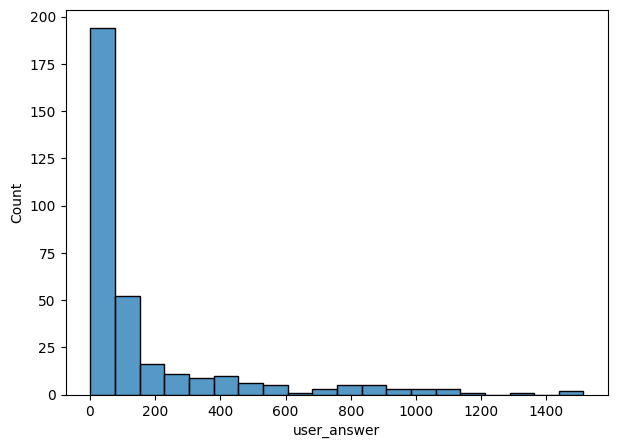

In [75]:
# Выводим распределение количества ответов студентов - похоже на нормальное распределение
plt.figure(figsize=(7,5))
sns.histplot(data = new_df,
            x='user_answer', bins = 20);

0.42657342657342656


<AxesSubplot: >

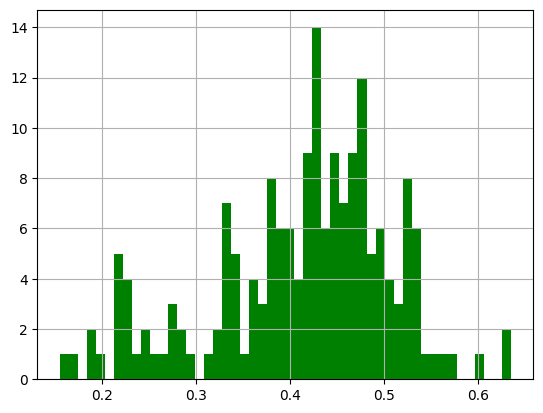

In [77]:
# Выводим распределение кол-ва ответов студентов, которое больше медианного, также похоже на нормальное
print(new_df.query('user_answer > 55')['cor_ratio'].median())
new_df.query('user_answer > 55')['cor_ratio'].hist(bins = 50, color = 'green')